# Test Model

### Notes:
1. Output metrics need to be given in SDR too
2. SNR's below 0 have high noise levels instead of low music levels - signal levels should be more randomised throughout the whole traning set. I'll to this by normalising the waveform after adding the noise, and then randomising the level to between 0 and -5 dB - this will allow me to double the training data from MUSDB18 by augmenting with different levels and noise masking.
3. use just MUSDB18 so I can present this as research.   
4. Given that I'm using the ESC50 set, i should be able to find what noise is what so I can label them when evaluating

In [1]:
import sys
import os

# Detect Google Colab
if "google.colab" in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Detect Google Colab
if "google.colab" in sys.modules:
    print("Running in Google Colab...")
    os.system("git clone https://github.com/CiaranMaloy/audioautoencoder")
    os.chdir("/content/audioautoencoder/")
    os.system("git pull")
    os.system("git checkout mel-warp")
    os.system("git pull origin mel-warp")
    #os.system("pip install --upgrade torchmetrics")
else:
    print("Running locally...")
    os.system("git pull origin mel-warp")
    #os.system("pip install --upgrade torchmetrics")


Running in Google Colab...


In [3]:
import sys
sys.path.append('/content/audioautoencoder')
sys.path.append('/content/audioautoencoder/audioautoencoder')

Notes on testing:
1. SDR is missing as a metric

## Load Model

In [4]:
from audioautoencoder.models.UNetConv4 import *
from audioautoencoder.training import DenoisingLoader

In [5]:
import torch

In [6]:
model_name = 'UNetConv4-mel-scale'
SNRdB_load = [-10, 10]
SNRdB = SNRdB_load
load_file = 'Autoencodermodel_earlystopping.pth'


load_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_{model_name}_{SNRdB_load[0]}-{SNRdB_load[1]}/{load_file}'

In [7]:
# Add the custom class to the safe globals list
torch.serialization.add_safe_globals([UNetConv4])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetConv4(in_channels=1, out_channels=1).to(device)

# Now load your checkpoint normally
denoiser = DenoisingLoader(model, load_path)
model = denoiser.model
print('Loaded Model')

# Example input (batch_size=1, channels=2, height=1025, width=175)
noisy_input = torch.randn(2, 1, 1025 // 4, 175)

denoised_output = denoiser.denoise(noisy_input)
print(denoised_output.shape)

Loaded model from /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv4-mel-scale_-10-10/Autoencodermodel_earlystopping.pth
Loaded Model
torch.Size([2, 1, 256, 175])


In [8]:
IMPORT_TEST_NOISY = True
load_dataframe = False
max_file_size_gb = 50

In [9]:
from audioautoencoder.datasets.utils import *
from audioautoencoder.data import *
from audioautoencoder.data_management import *
from audioautoencoder.generate_dataset import *

In [10]:
train_diffusion = False
SNRdB_load = [-10, 10]
SNRdBs = [[-10, 10]] # SNR random range
#load_file = 'Autoencodermodel_earlystopping.pth'
load_file = 'Autoencodermodel_checkpoint.pth'

folder = 'remapped-signal-level' # sep

output_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_{model_name}_{SNRdB_load[0]}-{SNRdB_load[1]}/'
scaler_file = output_path + "scalers.pkl"  # Static filename since it's unique per run
os.makedirs(os.path.dirname(scaler_file), exist_ok=True)
source_folder = f"/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_{folder}/SNRdB_{SNRdB[0]}-{SNRdB[1]}/"
source_path = source_folder + "test/"

In [11]:
destination_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/test/"

from google.colab import drive

if IMPORT_TEST_NOISY:
  if not os.path.exists(destination_path):
    combine_h5_files_spectrograms(source_path, destination_path, max_file_size_gb=max_file_size_gb)

In [12]:
from audioautoencoder.datasets.utils import *

In [13]:
dataset_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/test/combined_000.h5"

In [14]:
if os.path.exists(scaler_file):
    print("Loading existing scalers...")
    scalers = load_scalers(scaler_file)
else:
    print("Training new scalers...")
    scalers = train_scalers_separation(dataset_path, sample_size=8000)
    save_scalers(scalers, scaler_file)

Loading existing scalers...


In [15]:
if IMPORT_TEST_NOISY:
    print("Loading existing scalers...")
    scalers = load_scalers(scaler_file)
    test_loader = ChannelDatasetLoader(
          dataset_path=dataset_path,
          scalers=scalers,
          output_time_length=175,
          channels=1,
          snr_db=SNRdB,
          subset=False,
          batch_size=4
      )

    print(f"Training set size: {len(test_loader.train_dataset)}")
    print(f"Validation set size: {len(test_loader.val_dataset)}")

Loading existing scalers...
Training set size: 29901
Validation set size: 7476
Training set size: 29901
Validation set size: 7476


In [16]:
import os
os.system("pip install --upgrade torchmetrics")

0

In [17]:
from audioautoencoder.testing import *

In [18]:
if load_dataframe:
  df_subset = pd.read_csv(output_path + f"df_subset_SNRdB_{SNRdB[0]}-{SNRdB[1]}.csv")

## Test Model

Use a large amount of data for a general L1 score to be recorded as an overall performance

In [19]:
if not load_dataframe:
  criterion = nn.L1Loss()
  loss = test_model_gpu(model, test_loader.train_loader, criterion, scalers)
  print(f"Test Loss: {loss}")

Testing: 100%|██████████| 7476/7476 [09:11<00:00, 13.56batch/s, loss=0.1412]

Test Loss: 0.15120522000359987


   Epoch            Learning Rate  Train Loss  Validation Loss  Ref Loss  \
0      1                  [0.001]    0.221295         0.179640  0.348142   
1      2  [0.0009522542485937369]    0.179937         0.197721  0.341713   
2      3  [0.0008272542485937369]    0.166616         0.160529  0.335854   
3      4  [0.0006727457514062631]    0.156840         0.156083  0.330695   
4      5  [0.0005477457514062631]    0.149685         0.157470  0.326472   

   KL Beta  
0     0.00  
1     0.01  
2     0.02  
3     0.03  
4     0.04  


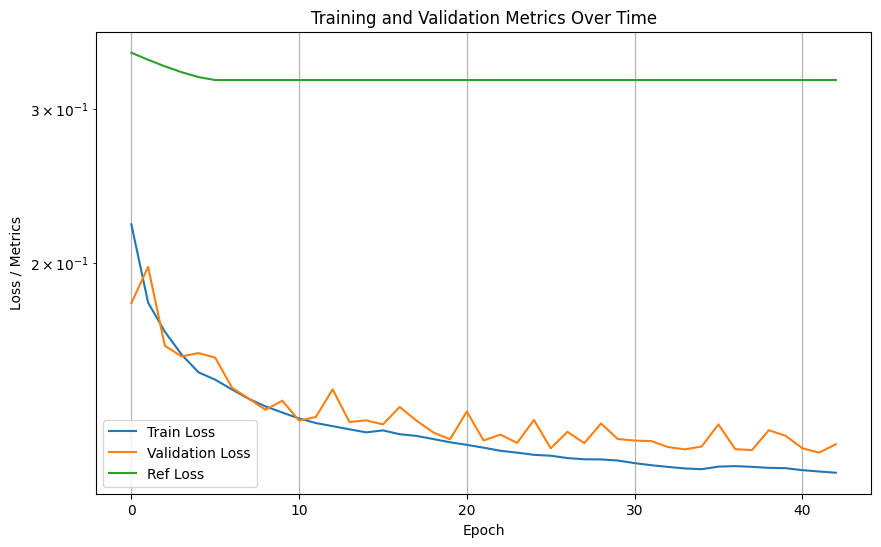

0     0.00
1     0.01
2     0.02
3     0.03
4     0.04
5     0.05
6     0.06
7     0.07
8     0.08
9     0.09
10    0.10
11    0.11
12    0.12
13    0.13
14    0.14
15    0.15
16    0.16
17    0.17
18    0.18
19    0.19
20    0.20
21    0.21
22    0.22
23    0.23
24    0.24
25    0.25
26    0.26
27    0.27
28    0.28
29    0.29
30    0.30
31    0.31
32    0.32
33    0.33
34    0.34
35    0.35
36    0.36
37    0.37
38    0.38
39    0.39
40    0.40
41    0.41
42    0.42
Name: KL Beta, dtype: float64


In [20]:
from audioautoencoder.plotting import *
csv_file_path = output_path + "training_log.csv"
plot_training_log(csv_file_path)

Use the val split as data for the more processing intensive df_eval generation, for a more in depth performance analysis

In [21]:
if not load_dataframe:
  criterion = nn.L1Loss()
  loss, df_eval = test_model(model, test_loader.val_loader, criterion, scalers)

Testing: 100%|██████████| 1869/1869 [02:26<00:00, 12.79batch/s, loss=0.1355]


In [22]:
if not load_dataframe:
  # Assuming `df` is your original dataframe
  #df_eval["Improvement"] = df_eval["l1_outvstar"] df_eval["l1_invstar"]  # Higher SDR is better
  subset_columns = ["instance", "l1_invstar", "l1_outvstar", "l1_invstar_4k", "l1_outvstar_4k", "l1_invstar_full", "l1_outvstar_full",  "filename", "snr_db"] #"Improvement"]
  df_subset = df_eval#[subset_columns]

In [23]:
if not load_dataframe:
  # Create a function to map filename to a class
  def get_class_from_filename(filename, classes):
      for keyword in classes:
          if keyword in filename:
              return keyword
      return 'Unknown'  # Default if no match found

  df_subset[['filename_audio', 'filename_noise']] = pd.DataFrame(df_subset['filename'].tolist(), index=df_subset.index)
  df_subset['filename_audio'] = df_subset['filename_audio'].apply(lambda x: x.decode('utf-8'))
  df_subset['filename_noise'] = df_subset['filename_noise'].apply(lambda x: x.decode('utf-8'))

  classes = ['mixture', 'vocals', 'drums', 'guitar', 'bass', 'piano', 'electric_guitar', 'acoustic_guitar', 'synthesizer', 'strings', 'brass']
  df_subset['audio_class'] = df_subset['filename_audio'].apply(lambda x: get_class_from_filename(x, classes))

  classes = ['0707', 'Rain', 'Crowd', 'Water', 'Ice']
  df_subset['noise_class'] = df_subset['filename_noise'].apply(lambda x: get_class_from_filename(x, classes))


In [25]:
df_subset["Improvement_L1"] = df_subset["l1_invstar"] - df_subset["l1_outvstar"]  # Lower L1 loss is better
#df_subset["Improvement_L1_4k"] = df_subset["l1_invstar_4k"] - df_subset["l1_outvstar_4k"]  # Lower L1 loss is better
#df_subset["Improvement_L1_full"] = df_subset["l1_invstar_full"] - df_subset["l1_outvstar_full"]  # Lower L1 loss is better

## Plot Results

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set minimal theme
sns.set_theme(style="white", font_scale=1.2)

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_eval = df_subset.copy()

# Round SNR to the nearest 2.5 dB
df_eval["snr_db_rounded"] = (df_eval["snr_db"] / 2.5).round() * 2.5

def compute_stats(df, class_col):
    grouped = df.groupby(["snr_db_rounded", class_col])["Improvement_L1"]
    stats = grouped.agg(["mean", "std", "count"]).reset_index()
    stats.rename(columns={
        "mean": "mean_improvement",
        "std": "std_improvement",
        "count": "count"
    }, inplace=True)
    return stats

df_audio_stats = compute_stats(df_eval, "audio_class")
df_noise_stats = compute_stats(df_eval, "noise_class")


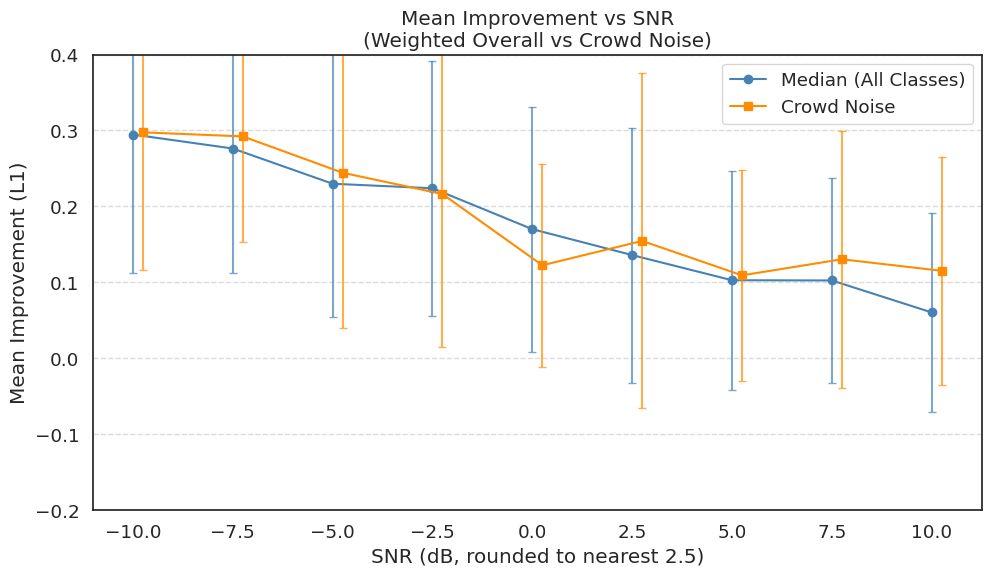

In [28]:
import numpy as np
plt.figure(figsize=(10, 6))

# Calculate weighted mean and std using counts
df_noise_stats["weighted_var"] = df_noise_stats["std_improvement"]**2 * df_noise_stats["count"]

grouped_all = df_noise_stats.groupby("snr_db_rounded").agg(
    mean_improvement=("mean_improvement", lambda x: np.median(x)), #weights=df_noise_stats.loc[x.index, "count"])),
    std_improvement=("weighted_var", lambda x: np.sqrt(np.sum(x) / np.sum(df_noise_stats.loc[x.index, "count"]))),
    total_count=("count", "sum")
).reset_index()

# Filter "Crowd" class
crowd_df = df_noise_stats[df_noise_stats["noise_class"] == "Crowd"]

# Plot weighted average
plt.plot(
    grouped_all["snr_db_rounded"],
    grouped_all["mean_improvement"],
    marker="o",
    label="Median (All Classes)",
    color="steelblue"
)
plt.errorbar(
    grouped_all["snr_db_rounded"],
    grouped_all["mean_improvement"],
    yerr=grouped_all["std_improvement"],
    fmt='none',
    capsize=3,
    color="steelblue",
    alpha=0.7
)

offset = 0.25
# --- Plot "Crowd" noise class (with slight offset) ---
plt.plot(
    crowd_df["snr_db_rounded"] + offset,
    crowd_df["mean_improvement"],
    marker="s",
    label="Crowd Noise",
    color="darkorange"
)
plt.errorbar(
    crowd_df["snr_db_rounded"] + offset,
    crowd_df["mean_improvement"],
    yerr=crowd_df["std_improvement"],
    fmt='none',
    capsize=3,
    color="darkorange",
    alpha=0.7
)

plt.xlabel("SNR (dB, rounded to nearest 2.5)")
plt.ylabel("Mean Improvement (L1)")
plt.title("Mean Improvement vs SNR\n(Weighted Overall vs Crowd Noise)")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.ylim((-0.2, 0.4))
plt.show()


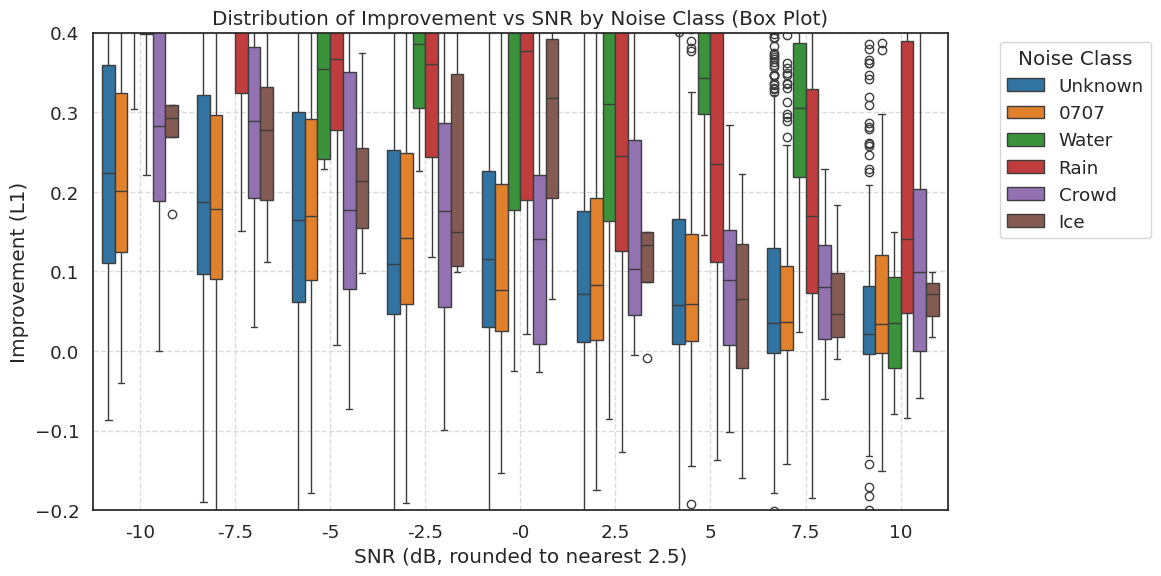

In [29]:
# Recalculate and clean labels
df_eval["snr_db_rounded"] = (df_eval["snr_db"] / 2.5).round() * 2.5

# Clean string labels and keep mapping for sorting
df_eval["snr_db_rounded_str"] = df_eval["snr_db_rounded"].apply(
    lambda x: f"{x:.1f}".rstrip('0').rstrip('.') if '.' in f"{x:.1f}" else f"{int(x)}"
)

# Sort labels numerically
ordered_snrs = sorted(df_eval["snr_db_rounded"].unique())
ordered_labels = [f"{x:.1f}".rstrip('0').rstrip('.') if '.' in f"{x:.1f}" else f"{int(x)}" for x in ordered_snrs]

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_eval,
    x="snr_db_rounded_str",
    y="Improvement_L1",
    hue="noise_class",
    palette="tab10",
    order=ordered_labels  # ✅ apply numeric order
)

plt.xlabel("SNR (dB, rounded to nearest 2.5)")
plt.ylabel("Improvement (L1)")
plt.title("Distribution of Improvement vs SNR by Noise Class (Box Plot)")
plt.legend(title="Noise Class", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.ylim((-0.2, 0.4))
plt.show()





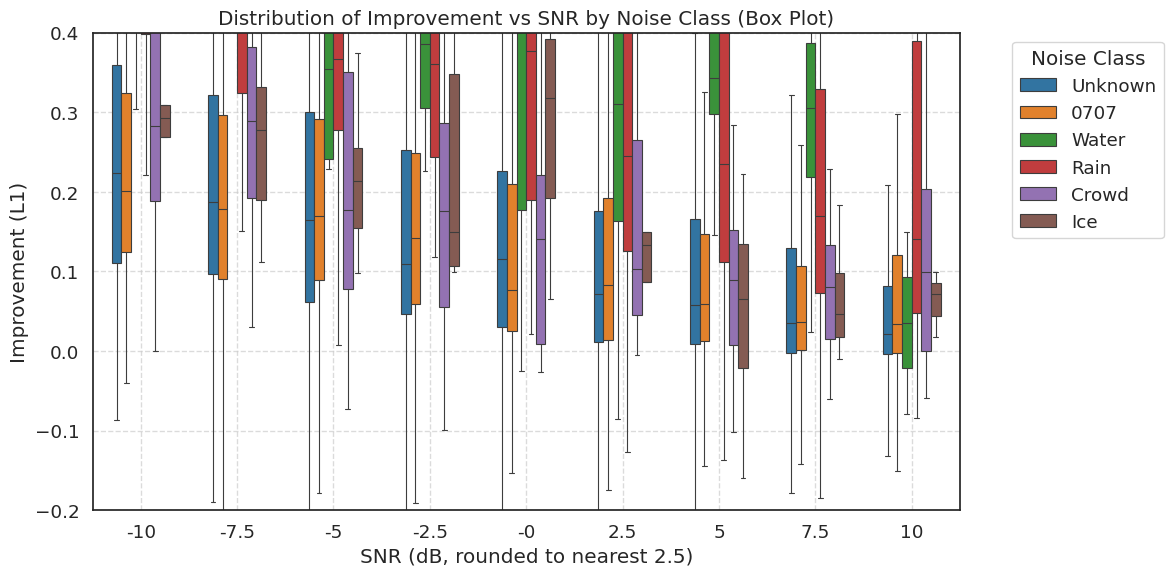

In [30]:

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_eval,
    x="snr_db_rounded_str",
    y="Improvement_L1",
    hue="noise_class",
    palette="tab10",
    order=ordered_labels,
    showfliers=False,  # Hide outliers
    linewidth=0.8,
    width=0.6
)

plt.xlabel("SNR (dB, rounded to nearest 2.5)")
plt.ylabel("Improvement (L1)")
plt.title("Distribution of Improvement vs SNR by Noise Class (Box Plot)")
plt.legend(title="Noise Class", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.ylim((-0.2, 0.4))
plt.show()


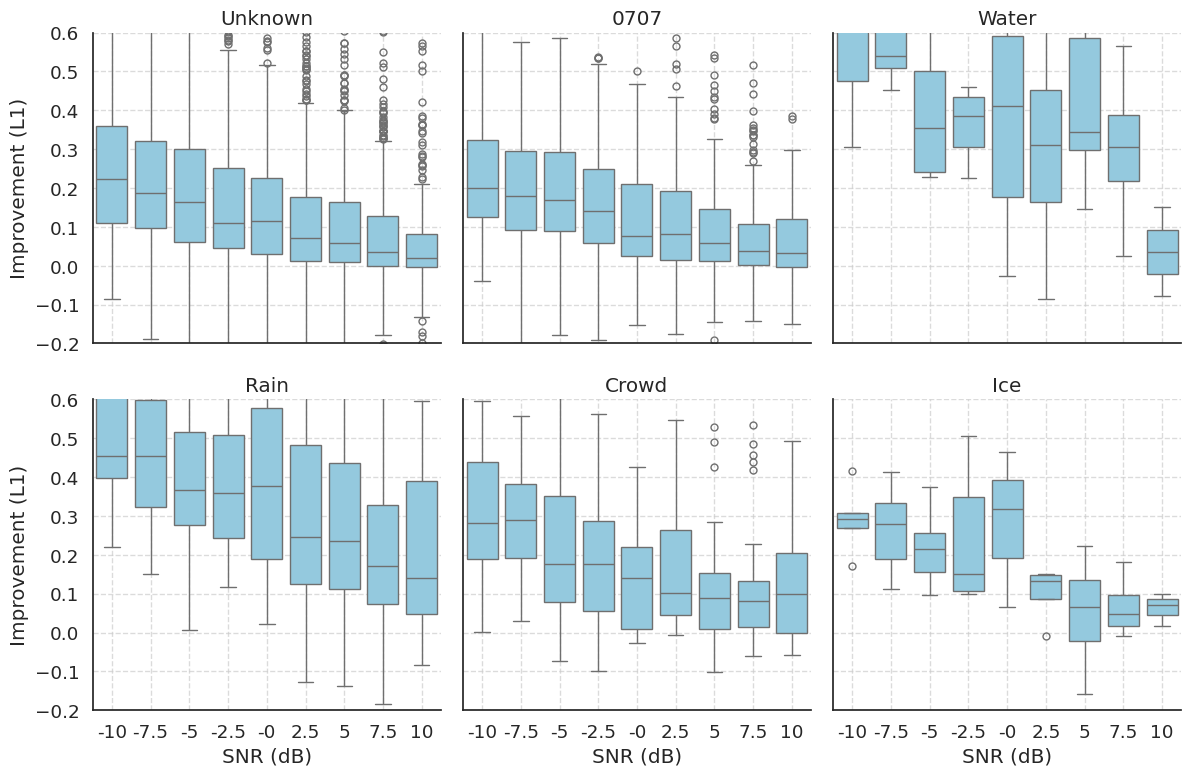

In [38]:
g = sns.catplot(
    data=df_eval,
    x="snr_db_rounded_str",
    y="Improvement_L1",
    col="noise_class",
    kind="box",
    col_wrap=3,
    order=ordered_labels,
    color="skyblue",  # ✅ uniform color for all boxes
    height=4,
    aspect=1
)

# Titles, labels, limits
g.set_titles(col_template="{col_name}")
g.set_axis_labels("SNR (dB)", "Improvement (L1)")
g.set(ylim=(-0.2, 0.6))

# ✅ Add horizontal gridlines to all facets
for ax in g.axes.flat:
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [32]:
# Save subset dataframe
df_subset.to_csv(output_path + f"df_subset_SNRdB_{SNRdB[0]}-{SNRdB[1]}.csv", index=False)

In [33]:
import gc

# Delete large variables

# Force garbage collection
gc.collect()

5216

## Plot Results

---